# Arbre de regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from math import log,sqrt,exp

import random
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import cycle
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_graphviz
import six
from six import StringIO  
import pydotplus
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Chargement et mise en forme des données

In [2]:
PATH = '../requetes/'
data = pd.read_csv(PATH+'requetes_total.csv')
data.head()

,avatar_id,city,date,language,mobile,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,29822,madrid,2,bulgarian,0,127,69,0,Independant,Independant,1,0,0
1,29822,madrid,2,bulgarian,0,941,67,0,Independant,Independant,1,0,0
2,29822,madrid,2,bulgarian,0,186,129,0,Yin Yang,Ardisson,1,0,0
3,29822,madrid,2,bulgarian,0,633,148,2,Morriott International,CourtYord,0,0,0
4,29822,madrid,2,bulgarian,0,241,126,0,Boss Western,J.Halliday Inn,1,0,0


In [3]:
# transformation des données en fonction de celles qu'on a identifié dans le notebook d'analyse des données de requetes
data["price_mod"]=data["price"].map(lambda x: log(x))
data["stock_mod"]=data["stock"].map(lambda x: sqrt(x))
data_mod = data.drop(["price","stock"],axis=1)

Pour la mise en forme des données, je décide d'ajouter une colonne order_request, comme dans le set de test. 

Les lignes qui sont issues du résultat de la même requête se caractérisent par un ID d'utilisateur constant, une ville et une date constantes. 

In [4]:
order = np.zeros(len(data_mod.index),dtype=int)

# référence pour le début = la première ligne du dataframe
ref_line = 0
order[0] = 1

for line in range(0,len(data_mod.index)):
    request_line = data_mod.loc[line,['avatar_id','city','date']].to_numpy()
    request_ref_line = data_mod.loc[ref_line,['avatar_id','city','date']].to_numpy() 
    if (request_line == request_ref_line).all() :
        order[line] = order[ref_line]
    else : 
        order[line] = order[ref_line]+1
        ref_line = line

In [5]:
data_mod['order_requests'] = order
data_mod.head()

,avatar_id,city,date,language,mobile,hotel_id,group,brand,parking,pool,children_policy,price_mod,stock_mod,order_requests
0,29822,madrid,2,bulgarian,0,127,Independant,Independant,1,0,0,4.234107,0.000000,1
1,29822,madrid,2,bulgarian,0,941,Independant,Independant,1,0,0,4.204693,0.000000,1
2,29822,madrid,2,bulgarian,0,186,Yin Yang,Ardisson,1,0,0,4.859812,0.000000,1
3,29822,madrid,2,bulgarian,0,633,Morriott International,CourtYord,0,0,0,4.997212,1.414214,1
4,29822,madrid,2,bulgarian,0,241,Boss Western,J.Halliday Inn,1,0,0,4.836282,0.000000,1


On change les types des variables.

In [6]:
# définition des variables quntitatives et qualitatives : 
var_quant = ["date","stock_mod"]
var_quali = ["city","language", "mobile","group","brand","parking","pool","children_policy"]

for var in var_quali :
    data_mod[var]=pd.Categorical(data_mod[var],ordered=False)

data_mod.dtypes

avatar_id             int64
city               category
date                  int64
language           category
mobile             category
hotel_id              int64
group              category
brand              category
parking            category
pool               category
children_policy    category
price_mod           float64
stock_mod           float64
order_requests        int64
dtype: object

In [7]:
# Renormalisation des variables quantitatives : 
scalerX = StandardScaler()  
scalerX.fit(data_mod[var_quant])  
X_quant = pd.DataFrame(scalerX.transform(data_mod[var_quant]),columns=var_quant)

# Séparation de l'output :
Y = data_mod["price_mod"].to_numpy()

In [8]:
# transformation des variables qualitatives en dummy variables
X_dum = pd.get_dummies(data_mod[var_quali])
X = pd.concat([data_mod[['order_requests','avatar_id','hotel_id']],X_quant,X_dum],axis=1)

# Fonctions utiles

In [9]:
def plot_pred_obs(Y_true,Y_pred): 
    plt.figure(figsize=(5,5))
    plt.plot(Y_true,Y_pred,"o",markersize = 0.4)
    plt.xlabel("prix prédit")
    plt.ylabel("prix observé")
    plt.show()

def scatterplot_residuals(Y_true,Y_pred):
    plt.figure(figsize=(5,5))
    plt.plot(Y_pred,Y_true-Y_pred,"o",markersize = 0.4)
    plt.xlabel(u"valeurs prédites")
    plt.ylabel(u"Résidus")
    plt.title("Residus pénalité L1 Lasso") 
    plt.hlines(0,0,3)
    plt.show()
    
def histogram_residuals(Y_true,Y_pred):
    plt.figure(figsize=(10,5))
    plt.hist(Y_true-Y_pred,bins=20)
    plt.title('histogramme des résidus')
    plt.xlabel('valeur des résidus')
    plt.ylabel('nombre de prédictions')
    plt.show()
    

In [10]:
def download_pred_Xtest(Y_pred,name_model) :
    Y_pred['index'] = Y_pred.index
    Y_pred = Y_pred[['index','price']]
    Y_pred.to_csv('../predictions/'+name_model+'.csv',index=False)

# Préparation des données de test 

In [11]:
# chargement des données de test : 
data_test = pd.read_csv('../Test_set_analysis/test_set_complet.csv')
data_test.dtypes

order_requests      int64
city               object
date                int64
language           object
mobile              int64
avatar_id           int64
hotel_id            int64
stock               int64
group              object
brand              object
parking             int64
pool                int64
children_policy     int64
dtype: object

In [12]:
# apply the same transformations on the test set : 
# qualitative variables to categorical 
for var in var_quali :
    data_test[var]=pd.Categorical(data_test[var],ordered=False)
    
# recentrer et renormaliser les variables : 
data_test["stock_mod"]=data_test["stock"].map(lambda x: sqrt(x))
data_test_mod = data_test.drop(["stock"],axis=1)
scaler_test = StandardScaler()  
scaler_test.fit(data_test_mod[var_quant])
X_test_quant = pd.DataFrame(scaler_test.transform(data_test_mod[var_quant]),columns=var_quant)

# transformation des variables qualitatives en dummy variables
X_test_dum = pd.get_dummies(data_test_mod[var_quali])
X_test = pd.concat([data_test_mod[['order_requests']],X_test_quant,X_test_dum],axis=1)

# Séparation des données en échantillon d'entrainement et validation

In [13]:
# 20% des avatar_ID seront dans le test set et 80% dans le train set
random.seed(0)
alpha = 0.8
ind_user = np.unique(data_mod['avatar_id'])
n = len(ind_user)
random.shuffle(ind_user)
ind_train = ind_user[:int(alpha*n)]
ind_vali = ind_user[int(alpha*n):]

# sélection des lignes correspondantes dans le dataframe 
X_train = X.loc[X['avatar_id'].isin(ind_train)]
X_vali = X.loc[X['avatar_id'].isin(ind_vali)]

In [14]:
# séparation de la colonne des outputs en training et validation : 
indX_train = X.index[X['avatar_id'].isin(ind_train)]
Y_train = Y[indX_train]
indX_vali = X.index[X['avatar_id'].isin(ind_vali)]
Y_vali = Y[indX_vali]

In [15]:
# suppression des ID maintenant qu'on en a plus besoin
X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)

/tmp/ipykernel_2936/883078845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
/tmp/ipykernel_2936/883078845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)


# Construction du modèle et analyse des résultats

In [32]:
param=[{"max_depth":list(range(20,35))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOptr=tree.fit(X_train, Y_train)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOptr.best_score_,treeOptr.best_params_))

Meilleur score = 0.037988, Meilleur paramètre = {'max_depth': 34}


In [33]:
treeR=DecisionTreeRegressor(max_depth=treeOptr.best_params_['max_depth']) #on optimise ici selon la profondeur
treeR.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=34)

## Prédiction de l'échantilon de validation

In [34]:
# prédiction de l'échantillon de validation
prev=treeR.predict(X_vali)

In [35]:
prev_detransfo = np.exp(prev)
Y_vali_detransfo = np.exp(Y_vali)

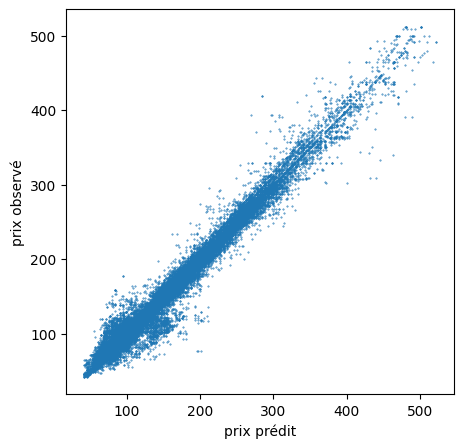

In [36]:
plot_pred_obs(Y_vali_detransfo,prev_detransfo)

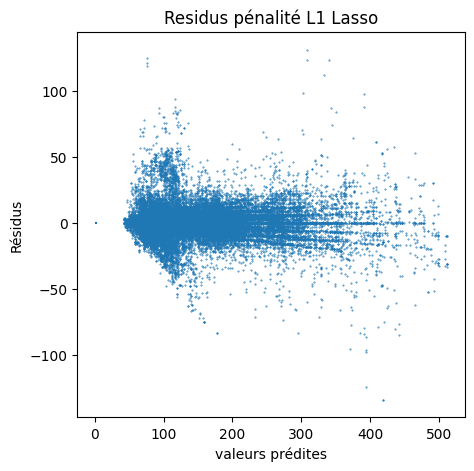

In [37]:
scatterplot_residuals(Y_vali_detransfo,prev_detransfo)

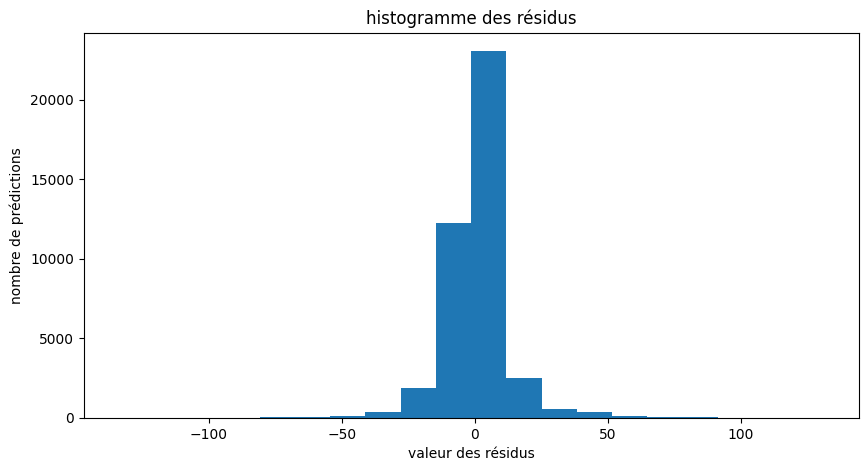

In [38]:
histogram_residuals(Y_vali_detransfo,prev_detransfo)

In [39]:
print("RMSE=",np.sqrt(mean_squared_error(Y_vali_detransfo,prev_detransfo)))
print("erreur généralisation Python = ", 1-treeOptr.score(X_vali,Y_vali_detransfo))

RMSE= 11.27678288543705
erreur généralisation Python =  4.894768537266819


## On réentraine le modèle sur toutes les données et on calcule la prédiction sur l'échantillon de test

In [29]:
param=[{"max_depth":list(range(20,35))}]
tree_complet = GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOptr_complet=tree_complet.fit(X.drop(['avatar_id','hotel_id'],axis=1), Y)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOptr_complet.best_score_,treeOptr_complet.best_params_))

Meilleur score = 0.034533, Meilleur paramètre = {'max_depth': 34}


In [30]:
treeR_complet=DecisionTreeRegressor(max_depth=treeOptr_complet.best_params_['max_depth']) #on optimise ici selon la profondeur
treeR_complet.fit(X.drop(['avatar_id','hotel_id'],axis=1), Y)

DecisionTreeRegressor(max_depth=34)

In [31]:
prev_test = treeR_complet.predict(X_test)
prev_test = pd.DataFrame(np.exp(prev_test),columns=['price'])
download_pred_Xtest(prev_test,'prediction_regression_tree')